In [50]:
import cascade as cs
import flow
import numpy as np
import tensortools as tt
import pandas as pd
import os
import matplotlib.pyplot as plt
import pool
# old_settings = np.seterr(divide='raise', invalid='raise')

## Updating code to work with a pairdate sorter

In [46]:
mouse='AS41'
tags=['replay1'],

# TCA params
rank=20
method=('ncp_bcd',)
replicates=3
fit_options=dict(tol=1e-4)

# tensor params
trace_type='zscore'
downsample=True
start_time=-1
end_time=6
verbose=True

# filtering params
exclude_tags=['disengaged', 'orientation_mapping', 'contrast', 'retinotopy']
drive_css=['0', '135', '270']
drive_css=['plus', 'minus', 'neutral']
drive_threshold=15

"""
Perform tensor component analysis (TCA) on data aligned
across pairs of days.

Algortitms from https://github.com/ahwillia/tensortools.

Parameters
-------
methods, tuple of str
    'cp_als', fits CP Decomposition using Alternating
        Least Squares (ALS).
    'ncp_bcd', fits nonnegative CP Decomposition using
        the Block Coordinate Descent (BCD) Method.
    'ncp_hals', fits nonnegtaive CP Decomposition using
        the Hierarcial Alternating Least Squares
        (HALS) Method.
    'mcp_als', fits CP Decomposition with missing data using
        Alternating Least Squares (ALS).

rank, int
    number of components you wish to fit

replicates, int
    number of initializations/iterations fitting for each rank

Returns
-------

"""

days = flow.metadata.DatePairSorter.frommeta(mice=[mouse], day_distance=(0, 7))

for day2, day1 in days:

    # get matched cell_ids for both days 
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])[day1.cells]
    d2_ids = flow.xday._read_crossday_ids(day2.mouse, day2.date)
    d2_ids = np.array([int(s) for s in d2_ids])[day2.cells]

    # filter cells based on visual/trial drive across all cs, prevent
    # breaking when only pavs are shown
    d1_drive = []
    d2_drive = []
    for cs in drive_css:
        try:
            d1_drive.append(pool.calc.driven.trial(day1, cs))
        except KeyError:
            print(str(day1) + ' requested ' + cs +
                  ': no match to what was shown (probably pav only).')
        try:
            d2_drive.append(pool.calc.driven.trial(day2, cs))
        except KeyError:
            print(str(day2) + ' requested ' + cs +
                  ': no match to what was shown (probably pav only).')
    d1_drive = np.max(d1_drive, axis=0)
    d2_drive = np.max(d2_drive, axis=0)

    # account for rare cases where lost xday ids are final id (making _ids
    # 1 shorter than _drive). Add a fake id to the end and force drive to
    # be false for that id
    if len(d1_drive) > len(d1_ids):
        print('Warning: ' + str(day1) + ': _ids was ' +
              str(len(d1_drive)-len(d1_ids)) +
              ' shorter than _drive: added pseudo-id.')
        d1_drive[-1] = 0
        d1_ids = np.concatenate((d1_ids, np.array([-1])))
    if len(d2_drive) > len(d2_ids):
        print('Warning: ' + str(day2) + ': _ids was ' +
              str(len(d2_drive)-len(d2_ids)) +
              ' shorter than _drive: added pseudo-id.')
        d2_drive[-1] = 0
        d2_ids = np.concatenate((d2_ids, np.array([-2])))

    d1_drive_ids = d1_ids[np.array(d1_drive) > drive_threshold]
    d2_drive_ids = d2_ids[np.array(d2_drive) > drive_threshold]
    all_driven_ids = np.concatenate((d1_drive_ids, d2_drive_ids), axis=0)
    d1_d2_drive = np.isin(d2_ids, all_driven_ids)
    d2_d1_drive = np.isin(d1_ids, all_driven_ids)
    # get all d1_ids that are present d2 and driven d1 or d2, (same for d2_ids)
    d1_ids_bool = np.isin(d1_ids, d2_ids[d1_d2_drive])
    d2_ids_bool = np.isin(d2_ids, d1_ids[d2_d1_drive])
    d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    d2_sorter = np.argsort(d2_ids[d2_ids_bool])

    # list of ids for pair of days
    ids = d1_ids[d1_ids_bool][d1_sorter]
    break
    # check that the sort worked
    if np.nansum(np.sort(d1_ids[d1_ids_bool]) - np.sort(d2_ids[d2_ids_bool])) != 0:
        print('Error: cell IDs were not matched between days: ' + str(day1) + ', ' + str(day2))
        continue

    # TODO add in additional filter for being able to check for quality of xday alignment

    # get all runs for both days
    d1_runs = day1.runs()
    d2_runs = day2.runs() # TODO add in training run_type as option 
    # filter for only runs without certain tags
    d1_runs = [run for run in d1_runs if not any(np.isin(run.tags, exclude_tags))]
    d2_runs = [run for run in d2_runs if not any(np.isin(run.tags, exclude_tags))]

    # build tensors for all correct runs and trials if you still have trials after filtering
    # day 1
    if d1_runs and d2_runs:
        d1_tensor_list = []
        d1_meta = []
        d2_tensor_list = []
        d2_meta = []
        for run in d1_runs:
            t2p = run.trace2p()
            # trigger all trials around stimulus onsets
            run_traces = t2p.cstraces('', start_s=start_time, end_s=end_time,
                                      trace_type=trace_type, cutoff_before_lick_ms=-1,
                                      errortrials=-1, baseline=(-1, 0),
                                      baseline_to_stimulus=True)
            # downsample all traces/timestamps to 15Hz if framerate is 31Hz
            if (t2p.d['framerate'] > 30) and downsample:
                # make sure divisible by 2
                sz = np.shape(run_traces)  # dims: (cells, time, trials)
                if sz[1] % 2 == 1:
                    run_traces = run_traces[:, :-1, :]
                    sz = np.shape(run_traces)
                # downsample
                ds_traces = np.zeros((sz[0], sz[1]//2, sz[2]))
                for trial in range(sz[2]):
                    a = run_traces[:, :, trial].reshape(sz[0], sz[1]//2, 2)
                    ds_traces[:, :, trial] = np.nanmean(a, axis=2)
                run_traces = ds_traces
            # filter and sort
            run_traces = run_traces[d1_ids_bool, :, :][d1_sorter, :, :]
            # get matched trial metadata/variables
            dfr = _trialmetafromrun(run)
            # drop trials with nans and add to list
            keep = np.sum(np.sum(np.isnan(run_traces), axis=0, keepdims=True),
                          axis=1, keepdims=True).flatten() == 0
            keep_inds = np.where(keep == True)[0]
            d1_tensor_list.append(run_traces[:, :, keep])
            d1_meta.append(dfr.loc[pd.IndexSlice[:, :, :, keep_inds], :])

        # day 2
        for run in d2_runs:
            t2p = run.trace2p()
            # trigger all trials around stimulus onsets
            run_traces = t2p.cstraces('', start_s=start_time, end_s=end_time,
                                      trace_type=trace_type, cutoff_before_lick_ms=-1,
                                      errortrials=-1, baseline=(-1, 0),
                                      baseline_to_stimulus=True)
            # downsample all traces/timestamps to 15Hz if framerate is 31Hz
            if (t2p.d['framerate'] > 30) and downsample:
                # make sure divisible by 2
                sz = np.shape(run_traces)  # dims: (cells, time, trials)
                if sz[1] % 2 == 1:
                    run_traces = run_traces[:, :-1, :]
                    sz = np.shape(run_traces)
                # downsample
                ds_traces = np.zeros((sz[0], sz[1]//2, sz[2]))
                for trial in range(sz[2]):
                    a = run_traces[:, :, trial].reshape(sz[0], sz[1]//2, 2)
                    ds_traces[:, :, trial] = np.nanmean(a, axis=2)
                run_traces = ds_traces
            # filter and sort
            run_traces = run_traces[d2_ids_bool, :, :][d2_sorter, :, :]
            # get matched trial metadata/variables
            dfr = _trialmetafromrun(run)
            # drop trials with nans and add to list
            keep = np.sum(np.sum(np.isnan(run_traces), axis=0, keepdims=True),
                          axis=1, keepdims=True).flatten() == 0
            keep_inds = np.where(keep == True)[0]
            d2_tensor_list.append(run_traces[:, :, keep])
            d2_meta.append(dfr.loc[pd.IndexSlice[:, :, :, keep_inds], :])

        # concatenate matched cells across trials 3rd dim (aka, 2)
        d1_tensor = np.concatenate(d1_tensor_list, axis=2)
        d2_tensor = np.concatenate(d2_tensor_list, axis=2)
        tensor = np.concatenate((d1_tensor, d2_tensor), axis=2)

        # concatenate all trial metadata in pd dataframe
        d1_meta.extend(d2_meta)
        pair_meta = pd.concat(d1_meta, axis=0)

        # create folder structure if needed
        save_dir = os.path.join(flow.paths.outd, str(day1.mouse))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        save_dir = os.path.join(save_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)

        # concatenate and save df for the day
        meta_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date)
                                 + '_' + str(day2.date) + '_df_pair_meta.pkl')
        input_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_tensor_' + str(trace_type) + '.npy')
        output_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
        pair_meta.to_pickle(meta_path)
        np.save(input_tensor_path, tensor, ids)

        # run TCA - iterate over different fitting methods
        ensemble = {}
        for m in method:
            ensemble[m] = tt.Ensemble(fit_method=m, fit_options=fit_options)
            ensemble[m].fit(tensor, ranks=range(1, rank+1), replicates=replicates, verbose=False)
        np.save(output_tensor_path, ensemble)

        # print output so you don't go crazy waiting
        if verbose:
            print('Pair: ' + str(c+1) + ': ' + str(day1.mouse) + ': ' +
                  str(day1.date) + ', ' + str(day2.date) + ': done.')
print('done.')

IndexError: index 44 is out of bounds for axis 0 with size 0

In [48]:
d1_ids

[]

In [5]:
mouse = 'OA27'
tags = None

# TCA params
rank=20
method=('ncp_bcd',)
replicates=3
fit_options=dict(tol=1e-4)

# tensor params
trace_type='zscore'
downsample=True
start_time=-1
end_time=6
verbose=True

# filtering params
exclude_tags=['disengaged', 'orientation_mapping', 'contrast', 'retinotopy']
drive_css=['0', '135', '270']
drive_threshold=15


days = flow.metadata.DateSorter.frommeta(mice=[mouse], tags=tags)

for c, day1 in enumerate(days, 0):

    try:
        day2 = days[c+1]
    except IndexError:
        print('done.')
        break

    # get cell_ids for both days and create boolean vec for cells
    # to use from each day
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])
    d2_ids = flow.xday._read_crossday_ids(day2.mouse, day2.date)
    d2_ids = np.array([int(s) for s in d2_ids])

    # filter cells based on visual/trial drive across all cs
#     d1_drive = np.max([pool.calc.driven.trial(day1, cs) for cs in drive_css], axis=0)
#     d2_drive = np.max([pool.calc.driven.trial(day2, cs) for cs in drive_css], axis=0)

    # filter cells based on visual/trial drive across all cs, prevent
    # breaking when only pavs are shown
    d1_drive = []
    d2_drive = []
    for cs in drive_css:
        try:
            d1_drive.append(pool.calc.driven.trial(day1, cs))
        except KeyError:
            print(str(day1) + ' requested ' + cs +
                  ': no match to what was shown (probably pav only).')
        try:
            d2_drive.append(pool.calc.driven.trial(day2, cs))
        except KeyError:
            print(str(day2) + ' requested ' + cs +
                  ': no match to what was shown (probably pav only).')
    d1_drive = np.max(d1_drive, axis=0)
    d2_drive = np.max(d2_drive, axis=0)

    # account for rare cases where lost xday ids are final id (making _ids
    # 1 shorter than _drive). Add a fake id to the end and force drive to
    # be false for that id
    if len(d1_drive) > len(d1_ids):
        print('Warning: ' + str(day1) + ': _ids was ' +
              str(len(d1_drive)-len(d1_ids)) +
              ' shorter than _drive: added pseudo-id.')
        d1_drive[-1] = 0
        d1_ids = np.concatenate((d1_ids, np.array([-1])))
    if len(d2_drive) > len(d2_ids):
        print('Warning: ' + str(day2) + ': _ids was ' +
              str(len(d2_drive)-len(d2_ids)) +
              ' shorter than _drive: added pseudo-id.')
        d2_drive[-1] = 0
        d2_ids = np.concatenate((d2_ids, np.array([-2])))

    d1_drive_ids = d1_ids[np.array(d1_drive) > drive_threshold]
    d2_drive_ids = d2_ids[np.array(d2_drive) > drive_threshold]
    all_driven_ids = np.concatenate((d1_drive_ids, d2_drive_ids), axis=0)
    d1_d2_drive = np.isin(d2_ids, all_driven_ids)
    d2_d1_drive = np.isin(d1_ids, all_driven_ids)
    # get all d1_ids that are present d2 and driven d1 or d2, (same for d2_ids)
    d1_ids_bool = np.isin(d1_ids, d2_ids[d1_d2_drive])
    d2_ids_bool = np.isin(d2_ids, d1_ids[d2_d1_drive])
    d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    d2_sorter = np.argsort(d2_ids[d2_ids_bool])

    break

In [8]:
d1_ids[d1_ids_bool][d1_sorter]
d2_ids[d2_ids_bool][d2_sorter]

array([   4,    7,    9,   10,   13,   14,   17,   19,   23,   24,   25,
         29,   30,   35,   39,   40,   41,   43,   46,   50,   51,   54,
         56,   58,   60,   64,   68,   71,   76,   80,   82,   83,   84,
         90,   91,   92,   93,   98,   99,  106,  108,  111,  113,  114,
        118,  120,  122,  125,  129,  131,  133,  134,  135,  138,  139,
        140,  144,  147,  149,  152,  170,  175,  177,  181,  183,  186,
        188,  190,  191,  194,  200,  201,  204,  205,  210,  211,  214,
        220,  224,  225,  229,  235,  236,  238,  239,  251,  497,  568,
        879, 1506])

264
253
139
128


(array([90., 49., 28., 10., 15.,  5.,  8., 10.,  9., 40.]),
 array([ 9.06789284, 12.85895633, 16.65001982, 20.44108331, 24.2321468 ,
        28.02321029, 31.81427378, 35.60533727, 39.39640076, 43.18746425,
        46.97852774]),
 <a list of 10 Patch objects>)

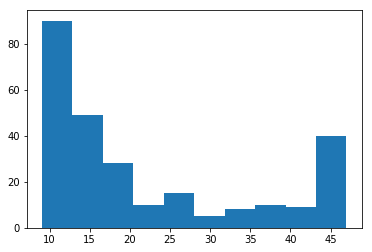

In [26]:
print(len(d1_drive))
print(len(d2_drive))

# print({ids: d1_drive[c] for c, ids in enumerate(d1_ids)})
print(len(d1_ids[np.array(d1_drive) >= 15]))
print(len(d2_ids[np.array(d2_drive) >= 15]))
# pd.concat(d1_meta, axis=0)
# d1_meta.extend(d2_meta)
# days = flow.metadata.DatePairSorter.frommeta(mice=['OA27'], day_distance=(0, 10))
plt.hist(d1_drive)

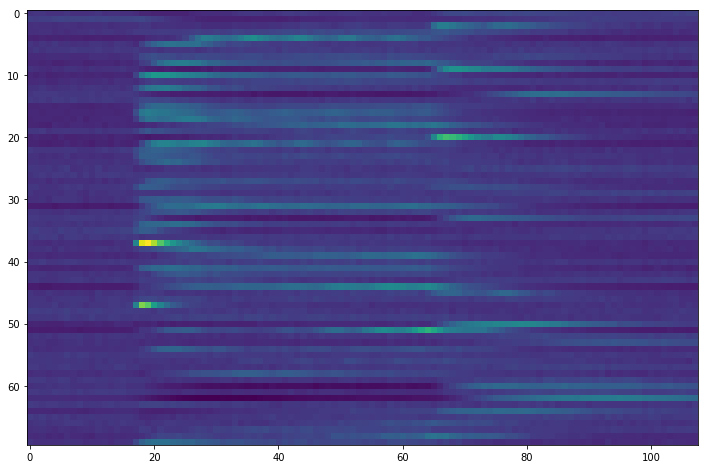

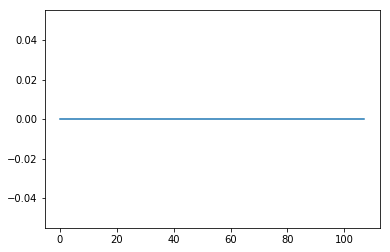

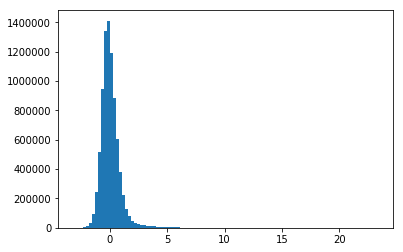

In [35]:
for i in range(0,np.shape(tensor)[1]):
    if np.sum((tensor[:,i,:]).flatten()) == 0:
        plt.figure()
        plt.imshow(np.isnan(tensor[:,:,i]))
        plt.title(i)

plt.figure(figsize=(100,8))
plt.imshow(np.squeeze(np.sum(tensor[:,:,:], axis=2)))
plt.figure()
plt.plot(np.sum(np.sum(tensor[:,:,:], axis=0), axis=1) == 0)
plt.figure()
x1 = plt.hist(tensor.flatten(), 100)

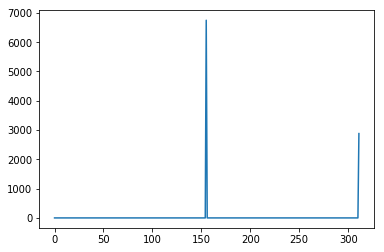

In [18]:
x = np.sum(np.sum(np.isnan(tensor), axis=0, keepdims=True), axis=1, keepdims=True)
# print(x)
plt.figure()
plt.plot(x.flatten())

In [51]:
days = flow.metadata.DateSorter.frommeta(mice=['OA26'], tags=None)
# days = flow.metadata.DatePairSorter.frommeta(mice=['OA27'], day_distance=(0, 10))
# pairdays = flow.metadata.DatePairSorter.frommeta(mice=[mouse], tags=tags)
exclude_tags = ['disengaged', 'orientation_mapping', 'contrast', 'retinotopy']
downsample = True
start_time = -1
end_time = 6
trace_type = 'zscore'

rank=20
method=('ncp_bcd',)
replicates=3
verbose=True
fit_options = dict(tol=1e-4)

# drive_css = ['plus', 'minus', 'neutral']
drive_css = ['0', '135', '270']
drive_threshold = 15

for c, day1 in enumerate(days, 0):
# for day1, day2 in days: 
    
    if c <= 9:
        continue
    # check that there is a subsequent day, otherwise exit
    try:
        day2 = days[c+1]
    except IndexError:
        print('done.')
        break
        
    # get cell_ids for both days and create boolean vec for cells to use from each day
    d1_ids = flow.xday._read_crossday_ids(day1.mouse, day1.date)
    d1_ids = np.array([int(s) for s in d1_ids])
    d2_ids = flow.xday._read_crossday_ids(day2.mouse, day2.date)
    d2_ids = np.array([int(s) for s in d2_ids])
    # filter cells based on visual/trial drive across all cs
#     d1_drive = np.max([pool.calc.driven.trial(day1, cs) for cs in drive_css], axis=0)
#     d2_drive = np.max([pool.calc.driven.trial(day2, cs) for cs in drive_css], axis=0)
    
    # filter cells based on visual/trial drive across all cs, prevent breaking when only pavs are shown
    d1_drive = []
    d2_drive = []
    for cs in drive_css:
        try:
            d1_drive.append(pool.calc.driven.trial(day1, cs))
        except KeyError:
            print(str(day1) + ' requested ' + cs + ': no match to what was shown (probably pav only).')
        try:
            d2_drive.append(pool.calc.driven.trial(day2, cs))
        except KeyError:
            print(str(day2) + ' requested ' + cs + ': no match to what was shown (probably pav only).')
    d1_drive = np.max(d1_drive, axis=0)
    d2_drive = np.max(d2_drive, axis=0)
    # account for rare cases where lost xday ids are final id (making _ids 1 shorter than _drive)
    # add a fake id to the end and force drive to be false for that id 
    if len(d1_drive) > len(d1_ids):
        print('Warning: ' + str(day1) + ': _ids was ' + str(len(d1_drive)-len(d1_ids)) + ' shorter than _drive: added pseudo-id.')
        d1_drive[-1] = 0
        d1_ids = np.concatenate((d1_ids, np.array([-1])))
    if len(d2_drive) > len(d2_ids):
        print('Warning: ' + str(day2) + ': _ids was ' + str(len(d2_drive)-len(d2_ids)) + ' shorter than _drive: added pseudo-id.')
        d2_drive[-1] = 0
        d2_ids = np.concatenate((d2_ids, np.array([-2])))
    d1_drive_ids = d1_ids[np.array(d1_drive) > drive_threshold]
    d2_drive_ids = d2_ids[np.array(d2_drive) > drive_threshold]
    all_driven_ids = np.concatenate((d1_drive_ids, d2_drive_ids), axis=0)
    d1_d2_drive = np.isin(d2_ids, all_driven_ids)
    d2_d1_drive = np.isin(d1_ids, all_driven_ids)
    # get all d1_ids that are present d2 and driven d1 or d2, (same for d2_ids)
    d1_ids_bool = np.isin(d1_ids, d2_ids[d1_d2_drive])
    d2_ids_bool = np.isin(d2_ids, d1_ids[d2_d1_drive])
    d1_sorter = np.argsort(d1_ids[d1_ids_bool])
    d2_sorter = np.argsort(d2_ids[d2_ids_bool])
    
    # check that the sort worked
    if np.nansum(np.sort(d1_ids[d1_ids_bool]) - np.sort(d2_ids[d2_ids_bool])) != 0:
        print('Error: cell IDs were not matched between days: ' + str(day1) + ', ' + str(day2))
        continue
    
    # TODO add in additional filter for being able to check for quality of xday alignment
    
    # get all runs for both days
    d1_runs = day1.runs()
    d2_runs = day2.runs()
    # filter for only runs without certain tags
    d1_runs = [run for run in d1_runs if not any(np.isin(run.tags, exclude_tags))]
    d2_runs = [run for run in d2_runs if not any(np.isin(run.tags, exclude_tags))]
    
    # build tensors for all correct runs and trials if you still have trials after filtering
    # day 1
    if d1_runs and d2_runs:
        d1_tensor_list = []
        d1_meta = []
        d2_tensor_list = []
        d2_meta = []
        for run in d1_runs:
            t2p = run.trace2p()
            # trigger all trials around stimulus onsets
            run_traces = t2p.cstraces('', start_s=start_time, end_s=end_time,
                                      trace_type=trace_type, cutoff_before_lick_ms=-1,
                                      errortrials=-1, baseline=(0, -1),
                                      baseline_to_stimulus=True)
            # downsample all traces/timestamps to 15Hz if framerate is 31Hz
            if (t2p.d['framerate'] > 30) and downsample:
                # make sure divisible by 2
                sz = np.shape(run_traces)  # dims: (cells, time, trials)
                if sz[1] % 2 == 1:
                    run_traces = run_traces[:, :-1, :]
                    sz = np.shape(run_traces)
                # downsample
                ds_traces = np.zeros((sz[0], sz[1]//2, sz[2]))
                for trial in range(sz[2]):
                    a = run_traces[:, :, trial].reshape(sz[0], sz[1]//2, 2)
                    ds_traces[:, :, trial] = np.nanmean(a, axis=2)
                run_traces = ds_traces
            # filter and sort
            run_traces = run_traces[d1_ids_bool,:,:][d1_sorter,:,:]
            # get matched trial metadata/variables
            dfr = trialmetafromrun(run)
            # drop trials with nans and add to list
            keep = np.sum(np.sum(np.isnan(run_traces), axis=0, keepdims=True), axis=1, keepdims=True).flatten() == 0
            keep_inds = np.where(keep == True)[0]
            d1_tensor_list.append(run_traces[:,:,keep])
            d1_meta.append(dfr.loc[pd.IndexSlice[:, :, :, keep_inds], :])
        
        # day 2
        for run in d2_runs:
            t2p = run.trace2p()
            # trigger all trials around stimulus onsets
            run_traces = t2p.cstraces('', start_s=start_time, end_s=end_time,
                                      trace_type=trace_type, cutoff_before_lick_ms=-1,
                                      errortrials=-1, baseline=(0, -1),
                                      baseline_to_stimulus=True)
            # downsample all traces/timestamps to 15Hz if framerate is 31Hz
            if (t2p.d['framerate'] > 30) and downsample:
                # make sure divisible by 2
                sz = np.shape(run_traces)  # dims: (cells, time, trials)
                if sz[1] % 2 == 1:
                    run_traces = run_traces[:, :-1, :]
                    sz = np.shape(run_traces)
                # downsample
                ds_traces = np.zeros((sz[0], sz[1]//2, sz[2]))
                for trial in range(sz[2]):
                    a = run_traces[:, :, trial].reshape(sz[0], sz[1]//2, 2)
                    ds_traces[:, :, trial] = np.nanmean(a, axis=2)
                run_traces = ds_traces
            # filter and sort
            run_traces = run_traces[d2_ids_bool,:,:][d2_sorter,:,:]
            # get matched trial metadata/variables
            dfr = trialmetafromrun(run)
            # drop trials with nans and add to list
            keep = np.sum(np.sum(np.isnan(run_traces), axis=0, keepdims=True), axis=1, keepdims=True).flatten() == 0
            keep_inds = np.where(keep == True)[0]
            d2_tensor_list.append(run_traces[:,:,keep])
            d2_meta.append(dfr.loc[pd.IndexSlice[:, :, :, keep_inds], :])
        
        # concatenate matched cells across trials 3rd dim (aka, 2)
        d1_tensor = np.concatenate(d1_tensor_list, axis=2)
        d2_tensor = np.concatenate(d2_tensor_list, axis=2)
        tensor = np.concatenate((d1_tensor, d2_tensor), axis=2)

        # concatenate all trial metadata in pd dataframe
        d1_meta.extend(d2_meta)
        pair_meta = pd.concat(d1_meta, axis=0)
        
        # create folder structure if needed
        save_dir = os.path.join(flow.paths.outd, str(day1.mouse))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        save_dir = os.path.join(save_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        # concatenate and save df for the day
        meta_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date) 
                                 + '_' + str(day2.date) + '_df_pair_meta.pkl')
        input_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date) 
                         + '_' + str(day2.date) + '_pair_tensor_' + str(trace_type) + '.npy')
        output_tensor_path = os.path.join(save_dir, str(day1.mouse) + '_' + str(day1.date) 
                         + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
        pair_meta.to_pickle(meta_path)
        np.save(input_tensor_path, tensor)
        break
#         if c <= 8:
#             continue
#         plt.hist(pair_tensor.flatten(), bins=100)
        # run TCA - iterate over different fitting methods
        ensemble = {}
#         old_settings = np.seterr(divide='raise', invalid='raise')
        for m in method:
            ensemble[m] = tt.Ensemble(fit_method=m, fit_options=fit_options)
            ensemble[m].fit(tensor, ranks=range(1, rank+1), replicates=replicates, verbose=False)
        np.save(output_tensor_path, ensemble)
        
        # print output so you don't go crazy waiting
        if verbose:
            print('Pair: ' + str(c+1) + ': ' + str(day1.mouse) + ': ' +
                  str(day1.date) + ', ' + str(day2.date) + ': done.')

['hungry', 'kelly', 'learning']


/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice


['hungry', 'kelly', 'learning']


/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice


['hungry', 'kelly', 'learning']
['hungry', 'kelly', 'learning']


KeyboardInterrupt: 

In [36]:
# print(dfr.head())
# print(dfr.index.get_level_values('trial_idx'))
# indexer = loc[pd.IndexSlice[:, ['ORD', 'DSM']], ['dep_time', 'dep_delay']]
print(dfr.loc[pd.IndexSlice[:, :, :, []], :])
# df2 = dfr.loc(indexer)
# print(df2)

                            orientation condition  trialerror  hunger  \
mouse date   run trial_idx                                              
OA27  170116 3   0                    0      plus           1  hungry   
                 1                  135   neutral           2  hungry   

                           learning_state       tag  firstlick  ensure  \
mouse date   run trial_idx                                               
OA27  170116 3   0                  naive  standard        NaN     NaN   
                 1                  naive  standard        NaN     NaN   

                            quinine  speed  
mouse date   run trial_idx                  
OA27  170116 3   0              NaN    NaN  
                 1              NaN    NaN  


In [54]:
test = ['hungry', 'kelly', 'learning']
'hungry' in test

True

In [50]:
def trialmetafromrun(RunSorter, trace_type='dff', start_time=-1, end_time=6,
              downsample=True, verbose=True):
    
    # get t2p object
    t2p = RunSorter.trace2p()

    # get the number of trials in your run
    try:
        trial_idx = range(t2p.ntrials)
    except:
        run_traces = t2p.cstraces('', start_s=start_time, end_s=end_time,
                          trace_type=trace_type, cutoff_before_lick_ms=-1,
                          errortrials=-1, baseline=(0, -1),
                          baseline_to_stimulus=True)
        trial_idx = range(np.shape(run_traces)[2])

    # get your learning-state
    run_tags = [str(s) for s in RunSorter.tags]
    print(run_tags)
    if 'naive' in run_tags:
        learning_state = 'naive'
    elif 'learning' in run_tags:
        learning_state = 'learning'
    elif 'reversal1' in run_tags:
        learning_state = 'reversal1'
    elif 'reversal2' in run_tags:
        learning_state = 'reversal2'
    learning_state = [learning_state]*len(trial_idx)

    # get hunger-state for all trials, consider hungry if not sated
    if 'sated' in run_tags:
        hunger = 'sated'
    else:
        hunger = 'hungry'
    hunger = [hunger]*len(trial_idx)

    # get relevant trial-distinguising tags excluding kelly, hunger-state, learning-state
    tags = [str(run_tags[s]) for s in range(len(run_tags)) if run_tags[s] != hunger[0]
            and run_tags[s] != learning_state[0]
            and run_tags[s] != 'kelly'
            and run_tags[s] != 'learning_start'
            and run_tags[s] != 'reversal1_start'
            and run_tags[s] != 'reversal2_start']
    if tags == []:  # define as "standard" if the run is not another option
        tags = ['standard']
    tags = [tags[0]]*len(trial_idx)

    # get trialerror ensuring you don't include runthrough at end of trials
    trialerror = np.array(t2p.d['trialerror'][trial_idx])

    # get cs and orientation info for each trial
    lookup = {v: k for k, v in t2p.d['codes'].items()}  # invert dict
    css = [lookup[s] for s in t2p.d['condition'][trial_idx]]
    oris = [t2p.d['orientations'][lookup[s]] for s in t2p.d['condition'][trial_idx]]

    # get mean running speed for time stim is on screen
    all_onsets = t2p.csonsets()
    all_offsets = t2p.d['offsets'][0:len(all_onsets)]
    if t2p.d['running'].size > 0:
        speed_vec = t2p.speed()
        speed_vec = speed_vec.astype('float')
        speed = []
        for s in trial_idx:
            try:
                speed.append(np.nanmean(speed_vec[all_onsets[s]:all_offsets[s]]))
            except:
                speed.append(np.nan)
        speed = np.array(speed)
    else:
        speed = np.full(len(trial_idx), np.nan)

    # get ensure/ensure/firstlick relative to triggered data
    ensure = t2p.ensure()
    ensure = ensure.astype('float')
    ensure[ensure == 0] = np.nan
    ensure = ensure - all_onsets + (np.abs(start_time)*np.round(t2p.d['framerate']))

    quinine = t2p.quinine()
    quinine = quinine.astype('float')
    quinine[quinine == 0] = np.nan
    quinine = quinine - all_onsets + (np.abs(start_time)*np.round(t2p.d['framerate']))

    firstlick = t2p.firstlick('')[trial_idx]
    firstlick = firstlick + (np.abs(start_time)*np.round(t2p.d['framerate']))

    # downsample all timestamps to 15Hz if framerate is 31Hz
    if (t2p.d['framerate'] > 30) and downsample:
        ensure = ensure/2
        quinine = quinine/2
        firstlick = firstlick/2

    # create your index out of relevant variables
    index = pd.MultiIndex.from_arrays([
                [RunSorter.mouse]*len(trial_idx),
                [RunSorter.date]*len(trial_idx),
                [RunSorter.run]*len(trial_idx),
                trial_idx
                ],
                names=['mouse', 'date', 'run', 'trial_idx'])

    data = {'orientation':  oris, 'condition': css,
            'trialerror': trialerror, 'hunger': hunger,
            'learning_state': learning_state, 'tag': tags,
            'firstlick': firstlick, 'ensure': ensure,
            'quinine': quinine, 'speed': speed}

    dfr = pd.DataFrame(data, index=index)
    
    return dfr